In [14]:
import numpy as np
import pandas as pd
import os, datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import Concatenate, Dense, Dropout

%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [15]:
#---Download Data---
print('Downloading Data')
movielens_data_name = 'data'
movielens_file_url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
movielens_file_md5 = '0e33842e24a9c977be4e0107933c0723'
movielens_data = keras.utils.get_file(origin=movielens_file_url, file_hash=movielens_file_md5, extract=True)

#---Load Data---
#define names for columns of data
ratings_df_names = ('user_id','movie_id', 'rating', 'timestamp')
movies_df_names = ('movie_id', 'movie_title', 'release_date',  'video_release_date',  'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical','Mystery','Romance','Sci-Fi', 'Thriller', 'War','Western')
genre_df_names = ('genre', 'genre_id')
users_df_names = ('user_id', 'age', 'gender', 'occupation', 'zip_code')

#load csv files with correct names and separators
df_ratings = pd.read_csv( os.path.splitext(movielens_data)[0] + '/u.data', sep='\t', names=ratings_df_names, encoding='latin')
df_movies = pd.read_csv( os.path.splitext(movielens_data)[0] + '/u.item', names=movies_df_names, sep='|', encoding='latin')
df_movie_genres = pd.read_csv( os.path.splitext(movielens_data)[0] + '/u.genre', names=genre_df_names, sep='|', encoding='latin')
df_users = pd.read_csv( os.path.splitext(movielens_data)[0] + '/u.user', names=users_df_names, sep='|', encoding='latin')
occupation_list = [e[0] for e in pd.read_csv( os.path.splitext(movielens_data)[0] + '/u.occupation', encoding='latin', usecols= [0]).values.tolist()] #very short -> normal python list

print('Data loaded')

Data loaded


# Data Analysis

First of all we are taking a look at the data we just downloaded.

The movielens dataset consists of multiple csv files that contain the following information:
- **users**: user id, age, gender, occupation, zip code
- **movies**: movie id, movie title, release date, video release date, IMDb URL, [GENRE]
- ***ratings***: user id, movie id, rating (1 to 5), timestamp

To get a better impression of the dataset we are going to look at the distribution of age of voters, review scores, gender

Age - mean:  34.05196182396607  median:  31.0  stddeviation:  12.18627315093721
Review Scores - mean:  3.52986  median:  4.0  stddeviation:  1.1256679707622492


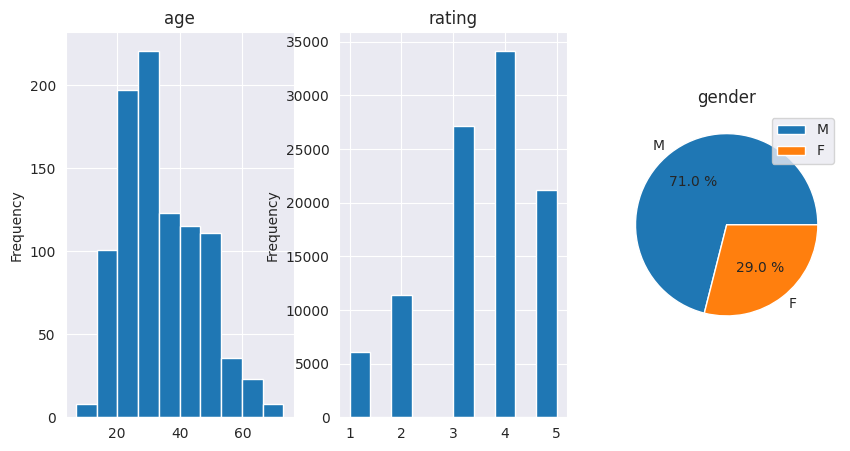

In [16]:
from matplotlib import pyplot as plt
#---Data Analysis---

fig, ax = plt.subplots(1, 3, figsize=(10,5))

df_users[users_df_names[1]].plot(kind='hist', ax = ax[0], title='age') #age histogram
df_ratings[ratings_df_names[2]].plot(kind='hist', ax = ax[1], title='rating') #rating histogram
df_users[users_df_names[2]].value_counts(normalize=True).plot.pie(ax = ax[2], autopct='%.1f %%', ylabel='', legend=True, title='gender') #gender pie chart


print('Age - mean: ', np.mean(df_users[users_df_names[1]]), ' median: ', np.median(df_users[users_df_names[1]]), ' stddeviation: ', np.std(df_users[users_df_names[1]] ))
print('Review Scores - mean: ', np.mean(df_ratings[ratings_df_names[2]]), ' median: ', np.median(df_ratings[ratings_df_names[2]]), ' stddeviation: ', np.std(df_ratings[ratings_df_names[2]] ))


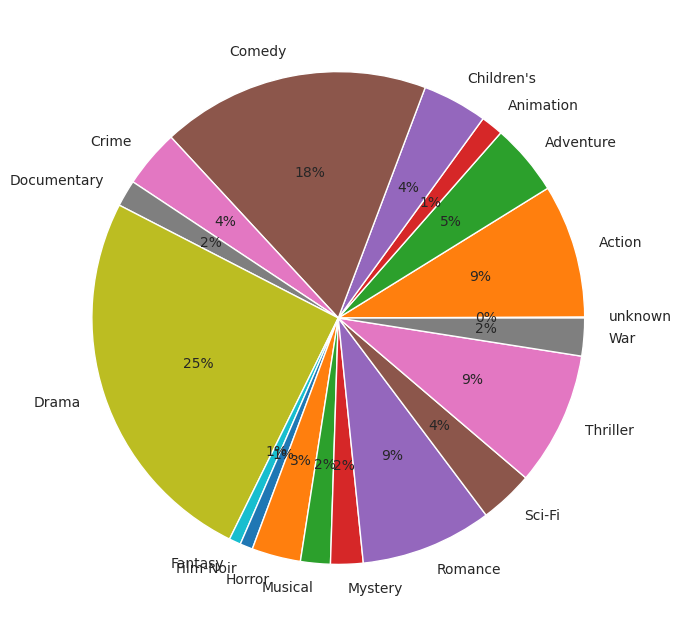

In [17]:
# Genre distribution
genre_names = movies_df_names[-19:-1] #list of all genre names
genre_series_dfs = [ df_movies[name] for name in genre_names ] #list of all genre serieses
genre_sums  = [series.sum() for series in genre_series_dfs]

plt.pie(genre_sums, normalize=True, labels=genre_names, autopct='%.0f%%')
# displaying chart
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()
#df_movies[d[3]].value_counts(normalize=True).plot.pie(autopct='%.1f %%', ylabel='', legend=True, figsize=(20, 10))

<AxesSubplot:>

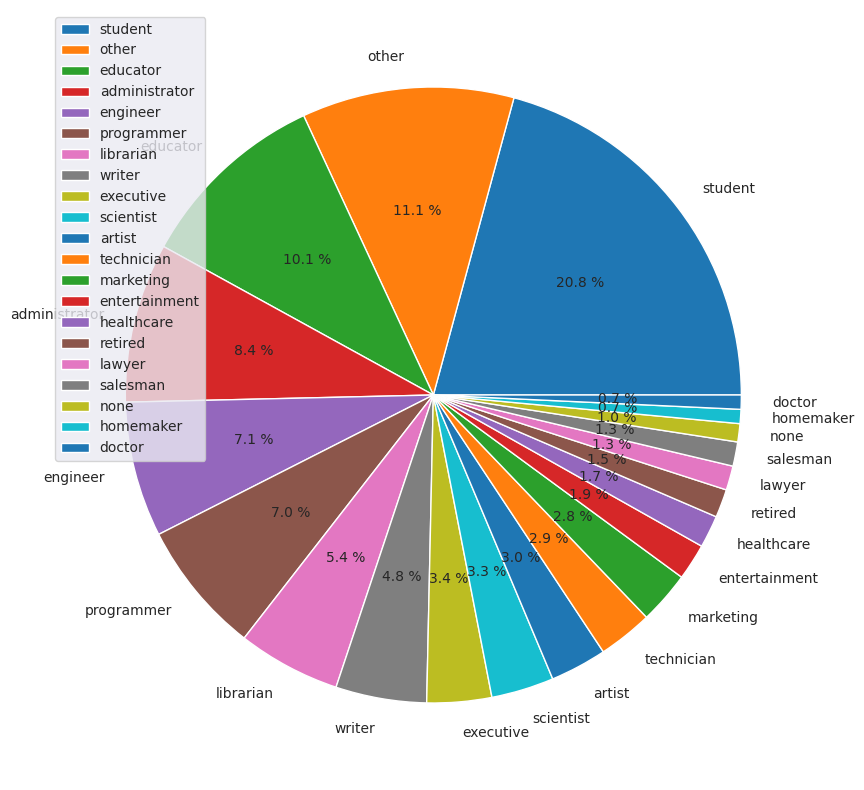

In [18]:
# job distribution
df_users[users_df_names[3]].value_counts(normalize=True).plot.pie(autopct='%.1f %%', ylabel='', legend=True, figsize=(20, 10))


## Learnings:
**users**:
   - 70% male
   - mostly 20 to 40 years old
   - 21% Students, others < 10%

**movies**
- 25% drama, 18% comedy, others < 10%

**ratings**
- mean rating: 3.5, most ratings in 3 to 5 star range

In [19]:
num_of_valid_video_release_dates  = len( df_movies[ np.isnan( df_movies[movies_df_names[3]] ) == False  ] )
print(f'The series with name {movies_df_names[3]} contains {num_of_valid_video_release_dates} valid out of {len(df_movies[movies_df_names[3]])} values.')

The series with name video_release_date contains 0 valid out of 1682 values.


In [20]:
#---Preprocessing---

#remove information, that will not be used
try:
    df_movies.drop([movies_df_names[4]], axis=1, inplace=True)#remove imdb urls
    df_ratings.drop([ratings_df_names[-1]], axis=1, inplace=True)#remove timestamps
except KeyError:
    pass #colums were already dropped

#encode IDs so that they start at 0. This is needed for the embedding layer to
encoder_user_id = LabelEncoder()
encoder_movie_id = LabelEncoder()
df_users['user_id_encoded'] = encoder_user_id.fit_transform(df_users[users_df_names[0]].values)
df_movies['movie_id_encoded'] = encoder_movie_id.fit_transform(df_movies[movies_df_names[0]].values)
#df_ratings['user_id_encoded'] = encoder_user_id.transform(df_ratings[ratings_df_names[0]].values)
df_ratings['movie_id_encoded'] = encoder_movie_id.transform(df_ratings[movies_df_names[0]].values)


#encode gender and occupation
encoder_gender = LabelEncoder()
encoder_occupation = LabelEncoder()
df_users['gender_encoded'] = encoder_gender.fit_transform(df_users[users_df_names[2]])
encoder_occupation.fit(df_users[users_df_names[3]].unique())
df_users['occupation_encoded'] = encoder_occupation.transform(df_users[users_df_names[3]])

#normalize ratings
min_rating = np.min(df_ratings[ratings_df_names[2]])
max_rating = np.max(df_ratings[ratings_df_names[2]])
funct_normalize_rating = lambda x: (x - min_rating) / (max_rating - min_rating) #source: https://keras.io/examples/structured_data/collaborative_filtering_movielens/
funct_denormalize_rating = lambda x: x * (max_rating - min_rating) + min_rating

df_ratings[ratings_df_names[2]] = df_ratings[ratings_df_names[2]].apply(funct_normalize_rating)
#df_ratings[ratings_df_names[2]] = df_ratings[ratings_df_names[2]].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

#calculation of some relevant dimensions of the dataset
num_of_users = df_ratings['user_id'].nunique()
num_of_movies = df_ratings['movie_id'].nunique()

#merge data
#df_ratings.drop('user_id_encoded', axis=1, inplace=True )
df_ratings = pd.merge(df_ratings, df_users, on='user_id')
#print(df_ratings.head())

print(f'Dataset Info: \n  Count of users: {num_of_users}, \n  Count of movies: {num_of_movies}, \n  Total ratings: {len(df_ratings[ratings_df_names[0]])}')

Dataset Info: 
  Count of users: 943, 
  Count of movies: 1682, 
  Total ratings: 100000


# The Models
Multiple models are created. Starting with a very simple one and improving upon it.

the main information and inspiration was gathered the following sites:
https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture
https://www.kaggle.com/code/indralin/movielens-project-1-3-deep-learning
https://medium.com/analytics-vidhya/how-to-make-a-movie-recommender-creating-a-recommender-engine-using-keras-and-tensorflow-a8e34c9ce48e


## Version No. 1 - Basic collaborative filtering
In this first version a simple collaborative filtering is implemented where the watch history of a user is compared with others and recommendations are made from there.

Neural network:
    input: user_id_encoded, movie_id_encoded
    output: rating

## Version No. 2 - Improvements
changes:
- introduction of a bias to improve fitting performance
- add a sigmoid activation layer as output layer to map the rating values from 0 to 1 and improve the learning.

## Version No. 3 - Adding a dense layer
changes:
- movie properties and user properties are stored in the embedding layers. Assessing the fit will now be done by a dense layer instead of a simple matrix multiplication
- added a dropout layer for regularization -> preventing overfitting

## Version No. 4 - BIG changes
changes:
- new inputs: age, gender, occupation
- more dense layers



In [21]:
#--- Prepare Data ----

X = df_ratings[['user_id_encoded', 'movie_id_encoded', 'occupation_encoded', 'gender_encoded','age']].values
y = df_ratings[ratings_df_names[-2]].values #ratings

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True) #split into train and test dataset
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.2)

x_train = [x_train[:, 0], x_train[:, 1], x_train[:, 2], x_train[:, 3], x_train[:, 4]] #rearange data for keras: list of the input arrays
x_val = [x_val[:, 0], x_val[:, 1], x_val[:, 2], x_val[:, 3], x_val[:, 4]]
x_test = [x_test[:, 0], x_test[:, 1], x_test[:, 2], x_test[:, 3], x_test[:, 4]]


print(f'Length of Dataset: Train: {len(y_train)}, Validate: {len(y_val)}, Test: {len(y_test)}')

# ONLY WORKING IN EAGER MODE -> very slow
# own metric that calculates the mean error on predictions rounded to valid review values
def round_result_metric(y_true, y_pred): #source: http://digital-thinking.de/keras-three-ways-to-use-custom-validation-metrics-in-keras/
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    _vectorized_funct_normalize_rating = np.vectorize(funct_normalize_rating) #vectorize function for best performance - https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array
    _vectorized_funct_denormalize_rating = np.vectorize(funct_denormalize_rating)

    y_pred = np.around(  _vectorized_funct_denormalize_rating(y_pred) ) #round ratings
    y_pred = np.vectorize(lambda x: min_rating if (x < min_rating) else max_rating if (x > max_rating) else x) (y_pred) #catch overflows in rating

    return np.mean(y_pred - _vectorized_funct_normalize_rating(y_true))

#tensorflow version of round_result_metric
def difference_of_rounded_rating(y_true, y_pred):
    y_true = tf.math.multiply(y_true, (max_rating - min_rating)) #scale percent to 1 to 5
    y_true = tf.math.add(y_true, min_rating)
    y_pred = tf.math.multiply(y_pred, (max_rating - min_rating))
    y_pred = tf.math.add(y_pred, min_rating)

    y_pred = tf.math.round(y_pred) #rounding to values smaller than 1 or bigger than 5 are not adressed

    return tf.math.reduce_mean(y_pred - y_true)


#--- Setup neural net ---

def build_rating_prediction_model_1_0(_num_of_users, _num_of_movies, _num_of_parameters_in_embedding_layer = 50):

    #define Inputlayer
    _inputlayer_user = Input(shape=(1,), name='User_ID Input')
    _inputlayer_movie = Input(shape=(1,), name='Movie_ID Input')

    #define embedding layers that characterize each user and movie
    _user_embedding = Embedding( _num_of_users,
                                 _num_of_parameters_in_embedding_layer,
                                 name='Embedding_User_ID',
                                 embeddings_initializer= 'he_normal',
                                 embeddings_regularizer= l2(1e-6) #l1 was giving worse results -> l2

                                 ) (_inputlayer_user)
    _user_embedding = Reshape( (_num_of_parameters_in_embedding_layer, ) ) (_user_embedding)

    _movie_embedding = Embedding( _num_of_movies,
                                 _num_of_parameters_in_embedding_layer,
                                 name='Embedding_Movie_ID',
                                 embeddings_initializer= 'he_normal',
                                 embeddings_regularizer= l2(1e-6)
                                 ) (_inputlayer_movie)
    _movie_embedding = Reshape( (_num_of_parameters_in_embedding_layer, ) ) (_movie_embedding)

    # output = rating
    # output is calculated as the product of the user matrix and the movie matrix
    _output_funct = Dot(axes=1, name='Output_Multiply')([_user_embedding, _movie_embedding])

    _model = Model( inputs=[_inputlayer_user, _inputlayer_movie], outputs= _output_funct ) #define model
    _optimizer = Adam(learning_rate=0.01) #use 'standard' optimizer

    _model.compile(loss='mean_squared_error', optimizer=_optimizer, metrics=[difference_of_rounded_rating])#, metrics= [round_result_metric], run_eagerly=True)
    _model.summary()

    return _model







Length of Dataset: Train: 80000, Validate: 16000, Test: 4000


In [22]:
#add bias to embedding layers
#introduce non linearity into output with a sigmoid layer
def build_rating_prediction_model_2_0(_num_of_users, _num_of_movies, _num_of_parameters_in_embedding_layer = 50):

    #define Inputlayer
    _inputlayer_user = Input(shape=(1,), name='User_ID Input')
    _inputlayer_movie = Input(shape=(1,), name='Movie_ID Input')

    #define embedding layers that characterize each user and movie
    _user_embedding = Embedding( _num_of_users,
                                 _num_of_parameters_in_embedding_layer,
                                 name='Embedding_User_ID',
                                 embeddings_initializer= 'he_normal',
                                 embeddings_regularizer= l2(1e-6) #l1 was giving worse results -> l2

                                 ) (_inputlayer_user)
    _user_embedding = Reshape( (_num_of_parameters_in_embedding_layer, ) ) (_user_embedding)
    _user_embedding_bias = Embedding(num_of_users, 1, name='User_Embedding_Bias') (_inputlayer_user)
    _user_embedding_bias = Reshape( (1, ) ) (_user_embedding_bias)


    _movie_embedding = Embedding( _num_of_movies,
                                 _num_of_parameters_in_embedding_layer,
                                 name='Embedding_Movie_ID',
                                 embeddings_initializer= 'he_normal',
                                 embeddings_regularizer= l2(1e-6)
                                 ) (_inputlayer_movie)
    _movie_embedding = Reshape( (_num_of_parameters_in_embedding_layer, ) ) (_movie_embedding)
    _movie_embedding_bias = Embedding(num_of_movies, 1, name='Movie_Embedding_Bias') (_inputlayer_movie)
    _movie_embedding_bias = Reshape( (1, ) ) (_movie_embedding_bias)

    # output = rating
    # output is calculated as the product of the user matrix and the movie matrix
    _output_funct = Dot(axes=1, name='Output_Multiply')([_user_embedding, _movie_embedding])
    _output_funct = Add()([_output_funct, _user_embedding_bias, _movie_embedding_bias ]) #Add Bias
    _output_funct = Activation('sigmoid') (_output_funct)


    _model = Model( inputs=[_inputlayer_user, _inputlayer_movie], outputs= _output_funct ) #define model
    _optimizer = Adam(learning_rate=0.01) #use 'standard' optimizer

    _model.compile(loss='mean_squared_error', optimizer=_optimizer, metrics=[difference_of_rounded_rating, ])#, metrics= [round_result_metric], run_eagerly=True)
    _model.summary()
    keras.utils.plot_model(_model, show_shapes=True)

    return _model


In [23]:
def build_rating_prediction_model_3_0(_num_of_users, _num_of_movies, _num_of_parameters_in_embedding_layer = 50):

    #define Inputlayer
    _inputlayer_user = Input(shape=(1,), name='User_ID Input')
    _inputlayer_movie = Input(shape=(1,), name='Movie_ID Input')

    #define embedding layers that characterize each user and movie
    _user_embedding = Embedding( _num_of_users,
                                 _num_of_parameters_in_embedding_layer,
                                 name='Embedding_User_ID',
                                 embeddings_initializer= 'he_normal',
                                 embeddings_regularizer= l2(1e-6) #l1 was giving worse results -> l2

                                 ) (_inputlayer_user)
    _user_embedding = Reshape( (_num_of_parameters_in_embedding_layer, ) ) (_user_embedding)



    _movie_embedding = Embedding( _num_of_movies,
                                 _num_of_parameters_in_embedding_layer,
                                 name='Embedding_Movie_ID',
                                 embeddings_initializer= 'he_normal',
                                 embeddings_regularizer= l2(1e-6)
                                 ) (_inputlayer_movie)
    _movie_embedding = Reshape( (_num_of_parameters_in_embedding_layer, ) ) (_movie_embedding)

    _movie_and_user_concatenate = Concatenate()([_user_embedding, _movie_embedding])
    _dropout_1 = Dropout(0.1)(_movie_and_user_concatenate)
    _Dense_user_movie = Dense(128, kernel_initializer='he_normal')(_dropout_1)



    _output_funct = Dense(1, kernel_initializer='he_normal')(_Dense_user_movie)
    _output_funct = Activation('sigmoid') (_output_funct)


    _model = Model( inputs=[_inputlayer_user, _inputlayer_movie], outputs= _output_funct ) #define model
    _optimizer = Adam(learning_rate=0.01) #use 'standard' optimizer

    _model.compile(loss='mean_squared_error', optimizer=_optimizer, metrics=[difference_of_rounded_rating, ])#, metrics= [round_result_metric], run_eagerly=True)
    _model.summary()
    keras.utils.plot_model(_model, show_shapes=True)

    return _model

In [24]:

def build_rating_prediction_model_4_0(_num_of_users, _num_of_movies, _num_of_parameters_in_embedding_layer = 50):
    #prepare extra data for this model
    num_of_occupations = df_users['occupation'].nunique()

    #define Inputlayer
    _inputlayer_user = Input(shape=(1,), name='User_ID Input')
    _inputlayer_movie = Input(shape=(1,), name='Movie_ID Input')
    _inputlayer_occupation = Input(shape=(1,), name='Occupation_Input')
    _inputlayer_gender = Input(shape=(1,), name='Gender_Input')
    _inputlayer_age = Input(shape=(1,), name='Age_Input')


    #define embedding layers that characterize each user and movie
    _user_embedding = Embedding( _num_of_users,
                                 _num_of_parameters_in_embedding_layer,
                                 name='Embedding_User_ID',
                                 embeddings_initializer= 'he_normal',
                                 embeddings_regularizer= l2(1e-6) #l1 was giving worse results -> l2

                                 ) (_inputlayer_user)
    _user_embedding = Reshape( (_num_of_parameters_in_embedding_layer, ) ) (_user_embedding)



    _movie_embedding = Embedding( _num_of_movies,
                                 _num_of_parameters_in_embedding_layer,
                                 name='Embedding_Movie_ID',
                                 embeddings_initializer= 'he_normal',
                                 embeddings_regularizer= l2(1e-6)
                                 ) (_inputlayer_movie)
    _movie_embedding = Reshape( (_num_of_parameters_in_embedding_layer, ) ) (_movie_embedding)

    _occupation_embedding = Embedding( num_of_occupations,
                                 _num_of_parameters_in_embedding_layer,
                                 name='Embedding_Occupation',
                                 embeddings_initializer= 'he_normal',
                                 embeddings_regularizer= l2(1e-6)
                                 ) (_inputlayer_occupation)
    _occupation_embedding = Reshape( (_num_of_parameters_in_embedding_layer, ) ) (_occupation_embedding)

    _movie_and_user_concatenate = Concatenate()([_user_embedding, _movie_embedding, _occupation_embedding])
    _dropout_1 = Dropout(0.1)(_movie_and_user_concatenate)
    _dense_user_movie = Dense(128, kernel_initializer='he_normal')(_dropout_1)

    _concatenate_all = Concatenate() ([_dense_user_movie, _inputlayer_age, _inputlayer_gender])

    _dense_all = Dense(64, kernel_initializer='he_normal' )(_concatenate_all)

    _output_funct = Dense(1, kernel_initializer='he_normal')(_dense_all)
    _output_funct = Activation('sigmoid') (_output_funct)


    _model = Model( inputs=[_inputlayer_user, _inputlayer_movie, _inputlayer_occupation, _inputlayer_gender, _inputlayer_age], outputs= _output_funct ) #define model
    _optimizer = Adam(learning_rate=0.01) #use 'standard' optimizer

    _model.compile(loss='mean_squared_error', optimizer=_optimizer, metrics=[difference_of_rounded_rating, ])#, metrics= [round_result_metric], run_eagerly=True)
    _model.summary()
    keras.utils.plot_model(_model, show_shapes=True)

    return _model

In [25]:
#--- TRAINING ---
num_of_parameters_in_embedding_layer = 100 #number of control elements in embedding layer per user and movie
#model = build_rating_prediction_model_1_0(num_of_users, num_of_movies, num_of_parameters_in_embedding_layer)
#model = build_rating_prediction_model_2_0(num_of_users, num_of_movies, num_of_parameters_in_embedding_layer)
#model = build_rating_prediction_model_3_0(num_of_users, num_of_movies, num_of_parameters_in_embedding_layer)
model_extended = build_rating_prediction_model_4_0(num_of_users, num_of_movies, num_of_parameters_in_embedding_layer)


#history = model.fit(x=[x_train[0], x_train[1]], y=y_train, batch_size=100, epochs=10, verbose=1, validation_data=([x_test[0], x_test[1]], y_test), callbacks=[tensorboard_callback])
history = model_extended.fit(x=x_train, y=y_train, batch_size=100, epochs=10, verbose=1, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

#%tensorboard --logdir logs

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_ID Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 Movie_ID Input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 Occupation_Input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 Embedding_User_ID (Embedding)  (None, 1, 100)       94300       ['User_ID Input[0][0]']          
                                                                                            

In [26]:
#---TEST---
#results = model.evaluate([x_test[0], x_test[1]], y_test, batch_size=10)  #source: https://www.tensorflow.org/guide/keras/train_and_evaluate
results = model_extended.evaluate(x_test, y_test, batch_size=10)  #source: https://www.tensorflow.org/guide/keras/train_and_evaluate
print(f'Results with Test Data: {results}')

400/400 [==============================] - 1s 2ms/step - loss: 0.2199 - difference_of_rounded_rating: 1.4525
Results with Test Data: [0.21991945803165436, 1.452499508857727]


In [27]:
#--- MODEL COMPARISON
num_of_parameters_in_embedding_layer = 100 #number of control elements in embedding layer per user and movie
basic_models = [build_rating_prediction_model_1_0(num_of_users, num_of_movies, num_of_parameters_in_embedding_layer),
                build_rating_prediction_model_2_0(num_of_users, num_of_movies, num_of_parameters_in_embedding_layer),
                build_rating_prediction_model_3_0(num_of_users, num_of_movies, num_of_parameters_in_embedding_layer)
                ]
advanced_model = build_rating_prediction_model_4_0(num_of_users, num_of_movies, num_of_parameters_in_embedding_layer)


batch_size = 100
epochs = 10
for model in basic_models:
    model.fit(x=[x_train[0], x_train[1]], y=y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_test[0], x_test[1]], y_test), callbacks=[tensorboard_callback])

advanced_model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

results = [model.evaluate([x_test[0], x_test[1]], y_test)  for model in basic_models ]
results.append(advanced_model.evaluate(x_test, y_test))

for i, result in enumerate(results):
    print(f'Model V{i+1}: least squares loss: {result[0]}, mean difference when score is rounded: {result[1]}')

print(results)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_ID Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 Movie_ID Input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 Embedding_User_ID (Embedding)  (None, 1, 100)       94300       ['User_ID Input[0][0]']          
                                                                                                  
 Embedding_Movie_ID (Embedding)  (None, 1, 100)      168200      ['Movie_ID Input[0][0]']         
                                                                                            

In [29]:
#---Recommendation---
def print_recommendations_for_random_user(_model, num_of_predictions = 10):
    selected_user_id = df_users[ users_df_names[0] ][np.random.randint(0, len(df_users)-1)] #select a random user by id
    movies_watched_id = df_ratings[ df_ratings[ratings_df_names[0]] == selected_user_id ] [ratings_df_names[1]].unique() #list of all movies that have been reviewed by the user
    df_unseen_movies = df_movies[ ~df_movies[movies_df_names[0]].isin(movies_watched_id) ].copy() #get all movies, the user has not seen yet

    user_id_array = np.repeat( encoder_user_id.transform((selected_user_id,)), len(df_unseen_movies) )

    predicted_ratings = _model.predict( [ user_id_array, df_unseen_movies['movie_id_encoded'].values ])
    predicted_ratings = np.vectorize(funct_denormalize_rating)(predicted_ratings) #scale to 1 to 5
    predicted_ratings = np.around(predicted_ratings, decimals=1) #round to 1 decimal

    df_unseen_movies['rating'] = predicted_ratings
    df_prediction = df_unseen_movies.nlargest(num_of_predictions, ['rating']  )

    print(f'--- The top {num_of_predictions} movie recommendations for User {selected_user_id} ---')
    print(f'User: ID {selected_user_id}, Age: {df_users[users_df_names[1]][selected_user_id]}, Gender: {df_users[users_df_names[2]][selected_user_id]}, Occupation: {df_users[users_df_names[3]][selected_user_id]}')

    i = 0
    for index, row in df_prediction.iterrows():
        if i >= num_of_predictions:
            break
        else:
            print(f'{i + 1}. \t Rating: {row["rating"]} \t Title: {row[movies_df_names[1]]}')
            i+=1



print_recommendations_for_random_user(basic_models[2])

47/47 [==============================] - 0s 904us/step
--- The top 10 movie recommendations for User 543 ---
User: ID 543, Age: 44, Gender: F, Occupation: other
1. 	 Rating: 4.3 	 Title: Fargo (1996)
2. 	 Rating: 4.3 	 Title: As Good As It Gets (1997)
3. 	 Rating: 4.3 	 Title: Close Shave, A (1995)
4. 	 Rating: 4.3 	 Title: Casablanca (1942)
5. 	 Rating: 4.3 	 Title: Manchurian Candidate, The (1962)
6. 	 Rating: 4.2 	 Title: Star Wars (1977)
7. 	 Rating: 4.2 	 Title: Godfather, The (1972)
8. 	 Rating: 4.2 	 Title: Wizard of Oz, The (1939)
9. 	 Rating: 4.2 	 Title: Sound of Music, The (1965)
10. 	 Rating: 4.2 	 Title: Kolya (1996)


# Evaluation

The Comparison shows that Model No. 3 performs best.
In spite of the effort I put in Model No. 4 it did not perform better.